In [129]:
import cv2
import numpy as np

def detect_circles(image):
    """
    Phát hiện tất cả các hình tròn trong hình ảnh bằng Hough Circle Transform.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Chuyển đổi sang ảnh xám
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)  # Làm mờ ảnh để giảm nhiễu
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, 
        minDist=gray.shape[0] // 8,  # Khoảng cách tối thiểu giữa các hình tròn
        param1=100,  # Canny edge detector higher threshold
        param2=30,   # Threshold for center detection
        minRadius=20,  # Bán kính tối thiểu của hình tròn
        maxRadius=400  # Bán kính tối đa của hình tròn
    )

    if circles is not None:
        # Convert các tọa độ và bán kính từ float sang integer
        circles = np.round(circles[0, :]).astype("int")
        return circles  # Trả về danh sách các hình tròn (x, y, r)
    else:
        return None

def draw_circles(image, circles):
    """
    Vẽ tất cả các hình tròn phát hiện trên ảnh.
    """
    output_image = image.copy()
    if circles is not None:
        for (x, y, r) in circles:
            # Vẽ vòng tròn (tâm, bán kính)
            cv2.circle(output_image, (x, y), r, (0, 255, 0), 4)  # Màu xanh lá, độ dày 4
            # Vẽ tâm của hình tròn (màu đỏ)
            cv2.circle(output_image, (x, y), 3, (0, 0, 255), -1)  # Màu đỏ, bán kính 3
    return output_image

# Main function to load the image, detect circles and show them
image_path = "frame_0203.jpg"  # Thay thế với đường dẫn ảnh của bạn
image = cv2.imread(image_path)

# Phát hiện các hình tròn trong ảnh
circles = detect_circles(image)

# Vẽ tất cả các hình tròn trên ảnh
output_image = draw_circles(image, circles)

# Lưu kết quả vào tệp hình ảnh
output_image_path = "detected_circles_output.jpg"  # Đặt tên file đầu ra
cv2.imwrite(output_image_path, output_image)  # Lưu ảnh với các hình tròn đã được vẽ

# Hiển thị kết quả
cv2.imshow("Detected Circles", output_image)

# Chờ nhấn phím bất kỳ để đóng cửa sổ hiển thị
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Image with detected circles saved as {output_image_path}")


Image with detected circles saved as detected_circles_output.jpg


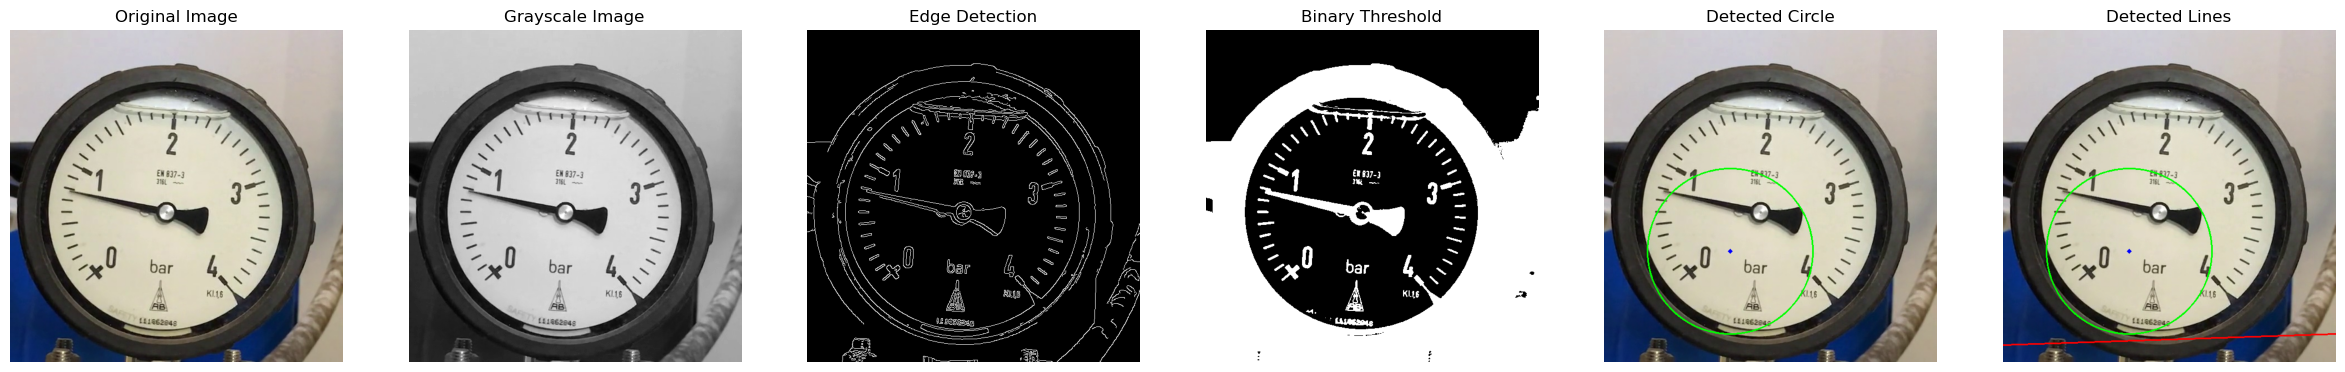

Detected Needle Angle: 338.17 degrees
Gauge Value: 4.00 bar


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_needle_detection_with_edges_and_circles(image_path):
    # Load the original image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for proper color display
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Perform edge detection using Canny
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        gray, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, 
        minDist=100, 
        param1=100, 
        param2=30, 
        minRadius=50, 
        maxRadius=150
    )
    
    # Draw detected circles on a copy of the image
    img_with_circle = img_rgb.copy()
    circle_center = None
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Draw the circle and its center
            cv2.circle(img_with_circle, (x, y), r, (0, 255, 0), 2)  # Green circle
            cv2.circle(img_with_circle, (x, y), 2, (0, 0, 255), 3)  # Red center
            circle_center = (x, y)  # Save the circle center
            break  # Assume the first detected circle is the gauge
    
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
    
    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi / 180, threshold=100,
                            minLineLength=10, maxLineGap=5)
    
    # Prepare a copy to draw detected lines
    img_with_lines = img_with_circle.copy()
    needle_angle = None
    if lines is not None and circle_center is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw lines in blue
            
            # Calculate the angle of the needle relative to the circle center
            dx = x2 - circle_center[0]
            dy = circle_center[1] - y2  # Invert Y-axis for proper angle calculation
            needle_angle = np.arctan2(dy, dx) * 180 / np.pi
            
            # Adjust angle to the range [0, 360]
            if needle_angle < 0:
                needle_angle += 360
            break  # Assume the first major line is the needle

    # Map the detected angle to the gauge value
    if needle_angle is not None:
        # Define the scale range (0 to 4 bar corresponds to angle range)
        min_angle = 45   # Minimum angle on the scale
        max_angle = 315  # Maximum angle on the scale
        min_value = 0    # Minimum value on the scale
        max_value = 4    # Maximum value on the scale
        
        # Map the needle angle to the value
        value = min_value + (needle_angle - min_angle) * (max_value - min_value) / (max_angle - min_angle)
        
        # Ensure the value is within the range
        if value < min_value:
            value = min_value
        elif value > max_value:
            value = max_value
    else:
        value = None

    # Visualize the steps
    plt.figure(figsize=(30, 6))

    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    # Grayscale image
    plt.subplot(1, 6, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")

    # Edge-detected image
    plt.subplot(1, 6, 3)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis("off")

    # Binary thresholded image
    plt.subplot(1, 6, 4)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Threshold")
    plt.axis("off")

    # Image with detected circle
    plt.subplot(1, 6, 5)
    plt.imshow(img_with_circle)
    plt.title("Detected Circle")
    plt.axis("off")

    # Image with detected lines
    plt.subplot(1, 6, 6)
    plt.imshow(img_with_lines)
    plt.title("Detected Lines")
    plt.axis("off")

    plt.show()
    
    return needle_angle, value

# Call the function with the uploaded image
image_path = 'frame_0203.jpg'
angle, value = visualize_needle_detection_with_edges_and_circles(image_path)

# Print the results
print(f"Detected Needle Angle: {angle:.2f} degrees")
print(f"Gauge Value: {value:.2f} bar")


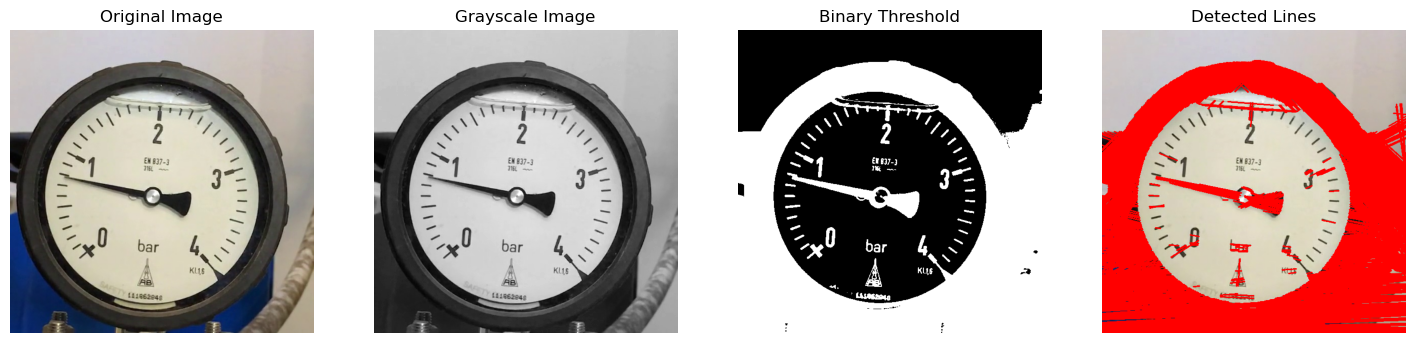

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_needle_detection_steps(image_path):
    # Đọc ảnh gốc
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển ảnh gốc sang RGB để hiển thị đúng màu
    
    # Chuyển sang thang độ xám
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Áp dụng ngưỡng nhị phân
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
    
    # Phát hiện đường thẳng bằng Hough Line Transform
    lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi / 180, threshold=100,
                            minLineLength=10, maxLineGap=5)
    
    # Tạo một bản sao để vẽ các đường thẳng phát hiện được
    img_with_lines = img_rgb.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Vẽ đường màu xanh dương

    # Hiển thị các bước
    plt.figure(figsize=(18, 6))

    # Ảnh gốc
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    # Ảnh thang độ xám
    plt.subplot(1, 4, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")

    # Ảnh nhị phân sau ngưỡng
    plt.subplot(1, 4, 3)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Threshold")
    plt.axis("off")

    # Ảnh có các đường thẳng phát hiện được
    plt.subplot(1, 4, 4)
    plt.imshow(img_with_lines)
    plt.title("Detected Lines")
    plt.axis("off")

    plt.show()

# Gọi hàm với đường dẫn ảnh
visualize_needle_detection_steps('frame_0203.jpg')


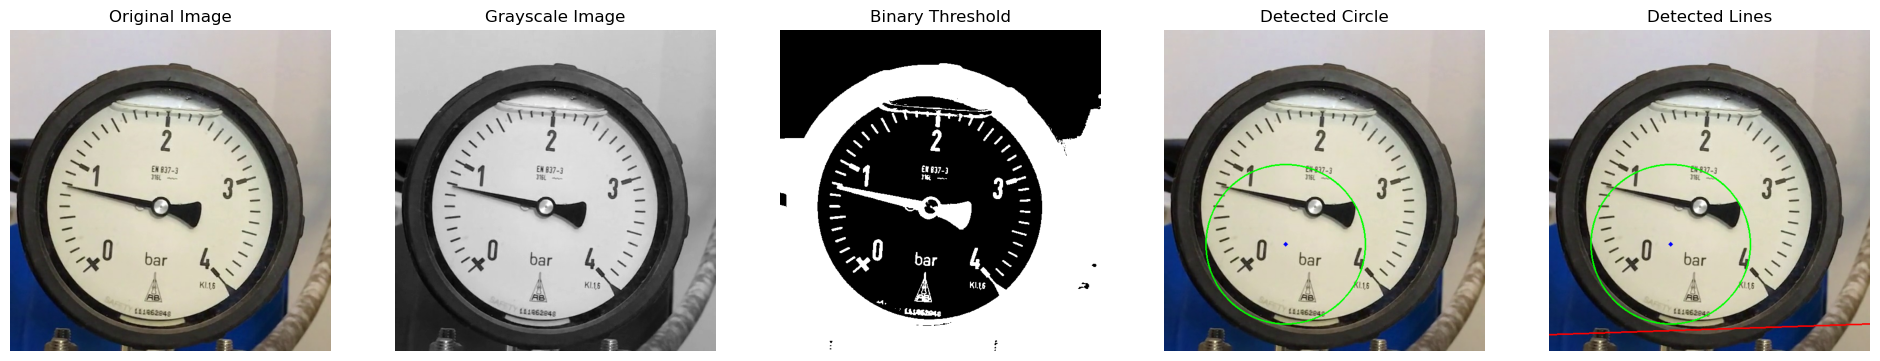

Detected Needle Angle: 338.17 degrees
Gauge Value: 4.00 bar


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_needle_detection_with_hough_circle(image_path):
    # Load the original image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for proper color display
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        gray, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2, 
        minDist=100, 
        param1=100, 
        param2=30, 
        minRadius=50, 
        maxRadius=150
    )
    
    # Draw detected circles on a copy of the image
    img_with_circle = img_rgb.copy()
    circle_center = None
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Draw the circle and its center
            cv2.circle(img_with_circle, (x, y), r, (0, 255, 0), 2)  # Green circle
            cv2.circle(img_with_circle, (x, y), 2, (0, 0, 255), 3)  # Red center
            circle_center = (x, y)  # Save the circle center
            break  # Assume the first detected circle is the gauge
    
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
    
    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi / 180, threshold=100,
                            minLineLength=10, maxLineGap=5)
    
    # Prepare a copy to draw detected lines
    img_with_lines = img_with_circle.copy()
    needle_angle = None
    if lines is not None and circle_center is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw lines in blue
            
            # Calculate the angle of the needle relative to the circle center
            dx = x2 - circle_center[0]
            dy = circle_center[1] - y2  # Invert Y-axis for proper angle calculation
            needle_angle = np.arctan2(dy, dx) * 180 / np.pi
            
            # Adjust angle to the range [0, 360]
            if needle_angle < 0:
                needle_angle += 360
            break  # Assume the first major line is the needle

    # Map the detected angle to the gauge value
    if needle_angle is not None:
        # Define the scale range (0 to 4 bar corresponds to angle range)
        min_angle = 45   # Minimum angle on the scale
        max_angle = 315  # Maximum angle on the scale
        min_value = 0    # Minimum value on the scale
        max_value = 4    # Maximum value on the scale
        
        # Map the needle angle to the value
        value = min_value + (needle_angle - min_angle) * (max_value - min_value) / (max_angle - min_angle)
        
        # Ensure the value is within the range
        if value < min_value:
            value = min_value
        elif value > max_value:
            value = max_value
    else:
        value = None

    # Visualize the steps
    plt.figure(figsize=(24, 6))

    # Original image
    plt.subplot(1, 5, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    # Grayscale image
    plt.subplot(1, 5, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")

    # Binary thresholded image
    plt.subplot(1, 5, 3)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Threshold")
    plt.axis("off")

    # Image with detected circle
    plt.subplot(1, 5, 4)
    plt.imshow(img_with_circle)
    plt.title("Detected Circle")
    plt.axis("off")

    # Image with detected lines
    plt.subplot(1, 5, 5)
    plt.imshow(img_with_lines)
    plt.title("Detected Lines")
    plt.axis("off")

    plt.show()
    
    return needle_angle, value

# Call the function with the uploaded image
image_path = 'frame_0203.jpg'
angle, value = visualize_needle_detection_with_hough_circle(image_path)

# Print the results
print(f"Detected Needle Angle: {angle:.2f} degrees")
print(f"Gauge Value: {value:.2f} bar")


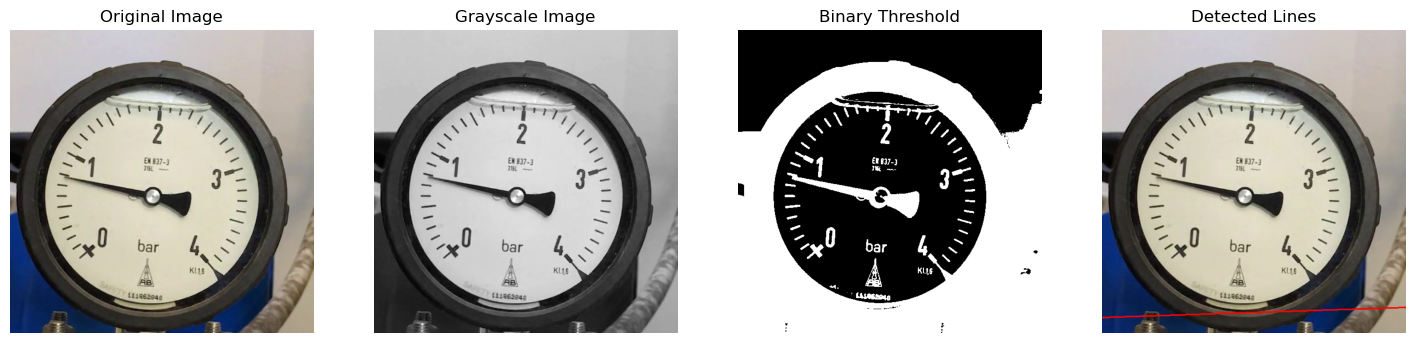

Detected Needle Angle: 358.09 degrees
Gauge Value: 4.00 bar


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_needle_detection_and_calculate_value(image_path):
    # Load the original image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for proper color display
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
    
    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi / 180, threshold=100,
                            minLineLength=10, maxLineGap=5)
    
    # Prepare a copy to draw detected lines
    img_with_lines = img_rgb.copy()
    needle_angle = None
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw lines in blue
            
            # Calculate the angle of the needle (assuming one major line is the needle)
            needle_angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            break  # Assuming the first line is the needle for simplicity

    # Map the detected angle to the gauge value
    if needle_angle is not None:
        # Adjust angle range to map correctly to the gauge
        if needle_angle < 0:
            needle_angle += 360
        
        # Define the scale range (0 to 4 bar corresponds to angle range)
        min_angle = 45   # Minimum angle on the scale
        max_angle = 315  # Maximum angle on the scale
        min_value = 0    # Minimum value on the scale
        max_value = 4    # Maximum value on the scale
        
        # Map the needle angle to the value
        value = min_value + (needle_angle - min_angle) * (max_value - min_value) / (max_angle - min_angle)
        
        # Ensure the value is within the range
        if value < min_value:
            value = min_value
        elif value > max_value:
            value = max_value
    else:
        value = None

    # Visualize the steps
    plt.figure(figsize=(18, 6))

    # Original image
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    # Grayscale image
    plt.subplot(1, 4, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis("off")

    # Binary thresholded image
    plt.subplot(1, 4, 3)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Threshold")
    plt.axis("off")

    # Image with detected lines
    plt.subplot(1, 4, 4)
    plt.imshow(img_with_lines)
    plt.title("Detected Lines")
    plt.axis("off")

    plt.show()
    
    return needle_angle, value

# Call the function with the uploaded image
image_path = 'frame_0203.jpg'
angle, value = visualize_needle_detection_and_calculate_value(image_path)

# Print the results
print(f"Detected Needle Angle: {angle:.2f} degrees")
print(f"Gauge Value: {value:.2f} bar")


In [9]:
import cv2
import numpy as np

def avg_circles(circles, b):
    avg_x, avg_y, avg_r = 0, 0, 0
    for i in range(b):
        avg_x += circles[0][i][0]
        avg_y += circles[0][i][1]
        avg_r += circles[0][i][2]
    avg_x = int(avg_x / b)
    avg_y = int(avg_y / b)
    avg_r = int(avg_r / b)
    return avg_x, avg_y, avg_r

def dist_2_pts(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calibrate_gauge(image_path):
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, 1, 20, np.array([]), 100, 50, int(height * 0.35), int(height * 0.48)
    )

    a, b, c = circles.shape
    x, y, r = avg_circles(circles, b)

    cv2.circle(img, (x, y), r, (0, 0, 255), 3, cv2.LINE_AA)
    cv2.circle(img, (x, y), 2, (0, 255, 0), 3, cv2.LINE_AA)

    separation = 10.0
    interval = int(360 / separation)
    p1 = np.zeros((interval, 2))
    p2 = np.zeros((interval, 2))
    for i in range(interval):
        for j in range(2):
            if j % 2 == 0:
                p1[i][j] = x + 0.9 * r * np.cos(separation * i * np.pi / 180)
            else:
                p1[i][j] = y + 0.9 * r * np.sin(separation * i * np.pi / 180)

    for i in range(interval):
        for j in range(2):
            if j % 2 == 0:
                p2[i][j] = x + r * np.cos(separation * i * np.pi / 180)
            else:
                p2[i][j] = y + r * np.sin(separation * i * np.pi / 180)

    min_angle = 135
    max_angle = 315
    min_value = 0
    max_value = 4
    units = "bar"

    return min_angle, max_angle, min_value, max_value, units, x, y, r

def get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

    lines = cv2.HoughLinesP(binary, rho=3, theta=np.pi / 180, threshold=100, minLineLength=10, maxLineGap=0)
    final_line_list = []

    diff1LowerBound = 0.15
    diff1UpperBound = 0.25
    diff2LowerBound = 0.5
    diff2UpperBound = 1.0

    for line in lines:
        for x1, y1, x2, y2 in line:
            diff1 = dist_2_pts(x, y, x1, y1)
            diff2 = dist_2_pts(x, y, x2, y2)
            if diff1 > diff2:
                diff1, diff2 = diff2, diff1

            if ((diff1 < diff1UpperBound * r) and (diff1 > diff1LowerBound * r) and 
                (diff2 < diff2UpperBound * r) and (diff2 > diff2LowerBound * r)):
                final_line_list.append([x1, y1, x2, y2])

    x1, y1, x2, y2 = final_line_list[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    dist_pt_0 = dist_2_pts(x, y, x1, y1)
    dist_pt_1 = dist_2_pts(x, y, x2, y2)
    if dist_pt_0 > dist_pt_1:
        x_angle = x1 - x
        y_angle = y - y1
    else:
        x_angle = x2 - x
        y_angle = y - y2

    res = np.arctan2(float(y_angle), float(x_angle))
    res = np.rad2deg(res)
    if x_angle > 0 and y_angle > 0:
        final_angle = 270 - res
    if x_angle < 0 and y_angle > 0:
        final_angle = 90 - res
    if x_angle < 0 and y_angle < 0:
        final_angle = 90 - res
    if x_angle > 0 and y_angle < 0:
        final_angle = 270 - res

    old_range = max_angle - min_angle
    new_range = max_value - min_value
    new_value = (((final_angle - min_angle) * new_range) / old_range) + min_value

    return new_value

def main():
    image_path = 'frame_0203.jpg'

    min_angle, max_angle, min_value, max_value, units, x, y, r = calibrate_gauge(image_path)

    img = cv2.imread(image_path)
    value = get_current_value(img, min_angle, max_angle, min_value, max_value, x, y, r)
    print(f"Currebnt reading: {value:.2f} {units}")

if __name__ == "__main__":
    main()


Current reading: -4.78 bar


In [10]:
270/4

67.5

In [22]:
def avg_circles(circles, b):
    if circles is None or len(circles) == 0:
        raise ValueError("No circles detected!")
    avg_x, avg_y, avg_r = 0, 0, 0
    for i in range(b):
        avg_x += circles[i][0]
        avg_y += circles[i][1]
        avg_r += circles[i][2]
    avg_x = int(avg_x / b)
    avg_y = int(avg_y / b)
    avg_r = int(avg_r / b)
    return avg_x, avg_y, avg_r

def process_gauge_image(image_path):
    def detect_circles(gray):
        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=50, maxRadius=150
        )
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            return circles
        return None

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect circles
    circles = detect_circles(gray)
    if circles is None:
        raise ValueError("No circles detected in the image!")

    # Use the first detected circle
    x, y, r = avg_circles(circles, len(circles))

    # Draw circle and center for visualization
    cv2.circle(img, (x, y), r, (0, 0, 255), 3)
    cv2.circle(img, (x, y), 2, (0, 255, 0), 3)

    # Apply binary threshold
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

    # Detect lines using HoughLinesP
    lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
    if lines is not None:
        final_line_list = []
        for line in lines:
            for x1, y1, x2, y2 in line:
                diff1 = dist_2_pts(x, y, x1, y1)
                diff2 = dist_2_pts(x, y, x2, y2)
                if diff1 > diff2:
                    diff1, diff2 = diff2, diff1

                # Broaden filtering criteria for debugging purposes
                if (0.1 * r < diff1 < 0.3 * r and 0.4 * r < diff2 < 1.2 * r):
                    final_line_list.append([x1, y1, x2, y2])

        if final_line_list:
            # Assume the first detected line represents the needle
            x1, y1, x2, y2 = final_line_list[0]
            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Calculate the needle angle
            dist_pt_0 = dist_2_pts(x, y, x1, y1)
            dist_pt_1 = dist_2_pts(x, y, x2, y2)
            if dist_pt_0 > dist_pt_1:
                x_angle = x1 - x
                y_angle = y - y1
            else:
                x_angle = x2 - x
                y_angle = y - y2

            res = np.arctan2(float(y_angle), float(x_angle))
            angle = np.rad2deg(res)
            if angle < 0:
                angle += 360

            # Map the angle to the gauge value
            value = map_angle_to_value(angle)
            return value, img

    raise ValueError("No valid lines detected to represent the needle!")

def main():
    image_path = 'frame_0203.jpg'  # Replace with your image path
    try:
        gauge_value, output_img = process_gauge_image(image_path)

        if gauge_value is not None:
            print(f"Gauge Reading: {gauge_value:.2f} bar")
        else:
            print("Failed to determine the gauge value!")

        # Save the processed image for review
        output_path = 'processed_gauge.jpg'
        cv2.imwrite(output_path, output_img)
        print(f"Processed image saved to: {output_path}")
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()


Gauge Reading: 0.51 bar
Processed image saved to: processed_gauge.jpg


In [20]:
import cv2
import numpy as np
from tkinter import Tk, Label, Button, Scale, filedialog, HORIZONTAL, Canvas, Scrollbar
from PIL import Image, ImageTk

class GaugeApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Gauge Angle Adjustment and Processing")
        
        self.image_path = None
        self.original_image = None
        self.rotated_image = None
        self.angle = 0

        # Add GUI components
        self.label = Label(root, text="Open an Image to Start")
        self.label.pack()

        # Canvas with scrollbar for displaying images
        self.canvas_frame = Canvas(root, width=800, height=600, bg="white")
        self.scrollbar = Scrollbar(root, orient="vertical", command=self.canvas_frame.yview)
        self.canvas_frame.configure(yscrollcommand=self.scrollbar.set)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas_frame.pack(side="left", expand=True, fill="both")

        # Widgets for control
        self.angle_slider = Scale(root, from_=-180, to=180, orient=HORIZONTAL, label="Rotation Angle (°)")
        self.angle_slider.pack()

        self.open_button = Button(root, text="Open Image", command=self.open_image)
        self.open_button.pack()

        self.rotate_button = Button(root, text="Rotate Image", command=self.rotate_image)
        self.rotate_button.pack()

        self.process_button = Button(root, text="Process Gauge", command=self.process_gauge)
        self.process_button.pack()

        self.result_label = Label(root, text="")
        self.result_label.pack()

    def open_image(self):
        """Open an image file."""
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
        if not self.image_path:
            return
        self.original_image = cv2.imread(self.image_path)
        self.rotated_image = self.original_image.copy()
        self.display_image(self.original_image)
        self.label.config(text="Image Loaded. Use the slider to rotate and process.")

    def rotate_image(self):
        """Rotate the image based on the slider value."""
        if self.original_image is None:
            self.label.config(text="Please open an image first.")
            return
        self.angle = self.angle_slider.get()
        self.rotated_image = self.apply_rotation(self.original_image, self.angle)
        self.display_image(self.rotated_image)
        self.label.config(text=f"Image rotated by {self.angle}°.")

    def apply_rotation(self, image, angle):
        """Apply rotation to the image."""
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
        return rotated

    def display_image(self, image):
        """Display the image in the Tkinter canvas."""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        image_tk = ImageTk.PhotoImage(image_pil)

        # Clear canvas and add the image
        self.canvas_frame.delete("all")
        self.canvas_frame.image = image_tk  # Keep reference to avoid garbage collection
        self.canvas_frame.create_image(0, 0, anchor="nw", image=image_tk)
        self.canvas_frame.configure(scrollregion=self.canvas_frame.bbox("all"))

    def process_gauge(self):
        """Process the rotated image to determine the gauge value."""
        if self.rotated_image is None:
            self.label.config(text="Please rotate the image first.")
            return
        try:
            value = self.get_gauge_value(self.rotated_image)
            self.result_label.config(text=f"Gauge Value: {value:.2f} bar")
        except Exception as e:
            self.result_label.config(text=f"Error: {str(e)}")

    def get_gauge_value(self, image):
        """Process the gauge image to determine the value."""
        def detect_circles(gray):
            circles = cv2.HoughCircles(
                gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=50, maxRadius=150
            )
            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                return circles
            return None

        def dist_2_pts(x1, y1, x2, y2):
            return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect circles
        circles = detect_circles(gray)
        if circles is None:
            raise ValueError("No circles detected in the image!")

        x, y, r = circles[0]

        # Apply binary threshold
        _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

        # Detect lines
        lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
        if lines is None:
            raise ValueError("No lines detected for processing!")

        # Process the first detected line
        final_line_list = []
        for line in lines:
            for x1, y1, x2, y2 in line:
                diff1 = dist_2_pts(x, y, x1, y1)
                diff2 = dist_2_pts(x, y, x2, y2)
                if diff1 > diff2:
                    diff1, diff2 = diff2, diff1

                if (0.1 * r < diff1 < 0.3 * r and 0.4 * r < diff2 < 1.2 * r):
                    final_line_list.append([x1, y1, x2, y2])

        if not final_line_list:
            raise ValueError("No valid lines detected to represent the needle!")

        x1, y1, x2, y2 = final_line_list[0]

        # Calculate the needle angle
        dx, dy = x2 - x, y - y2  # Invert y-axis for correct orientation
        angle = np.rad2deg(np.arctan2(dy, dx))
        if angle < 0:
            angle += 360

        # Map the angle to the gauge value
        return self.map_angle_to_value(angle)

    def map_angle_to_value(self, angle, min_angle=135, max_angle=45, min_value=0, max_value=4):
        """Map the needle angle to the gauge value."""
        if angle < min_angle:
            angle += 360
        total_degrees = 360 - min_angle + max_angle
        value_per_degree = (max_value - min_value) / total_degrees
        value = min_value + (angle - min_angle) * value_per_degree
        return value


if __name__ == "__main__":
    root = Tk()
    app = GaugeApp(root)
    root.mainloop()


In [29]:
import cv2
import numpy as np
from tkinter import Tk, Label, Button, Scale, Entry, filedialog, HORIZONTAL, Canvas, Scrollbar
from PIL import Image, ImageTk

class GaugeApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Gauge Angle Adjustment and Processing")
        
        self.image_path = None
        self.original_image = None
        self.rotated_image = None
        self.angle = 0

        # Add GUI components
        self.label = Label(root, text="Open an Image to Start")
        self.label.pack()

        # Canvas with scrollbar for displaying images
        self.canvas_frame = Canvas(root, width=800, height=600, bg="white")
        self.scrollbar = Scrollbar(root, orient="vertical", command=self.canvas_frame.yview)
        self.canvas_frame.configure(yscrollcommand=self.scrollbar.set)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas_frame.pack(side="left", expand=True, fill="both")

        # Angle input section
        self.angle_slider = Scale(root, from_=-180, to=180, orient=HORIZONTAL, label="Rotation Angle (°)")
        self.angle_slider.pack()

        self.angle_entry = Entry(root, width=10)
        self.angle_entry.pack()
        self.angle_entry.insert(0, "0")  # Default value

        self.set_angle_button = Button(root, text="Set Angle", command=self.set_angle)
        self.set_angle_button.pack()

        self.open_button = Button(root, text="Open Image", command=self.open_image)
        self.open_button.pack()

        self.rotate_button = Button(root, text="Rotate Image", command=self.rotate_image)
        self.rotate_button.pack()

        self.process_button = Button(root, text="Process Gauge", command=self.process_gauge)
        self.process_button.pack()

        self.result_label = Label(root, text="")
        self.result_label.pack()

    def open_image(self):
        """Open an image file."""
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
        if not self.image_path:
            return
        self.original_image = cv2.imread(self.image_path)
        self.rotated_image = self.original_image.copy()
        self.display_image(self.original_image)
        self.label.config(text="Image Loaded. Use the slider or input angle to rotate and process.")

    def set_angle(self):
        """Set the rotation angle from the entry box."""
        try:
            angle = float(self.angle_entry.get())
            if -180 <= angle <= 180:
                self.angle_slider.set(angle)
                self.label.config(text=f"Angle set to {angle}°.")
            else:
                self.label.config(text="Angle must be between -180 and 180.")
        except ValueError:
            self.label.config(text="Invalid angle. Please enter a numeric value.")

    def rotate_image(self):
        """Rotate the image based on the slider value."""
        if self.original_image is None:
            self.label.config(text="Please open an image first.")
            return
        self.angle = self.angle_slider.get()
        self.rotated_image = self.apply_rotation(self.original_image, self.angle)
        self.display_image(self.rotated_image)
        self.label.config(text=f"Image rotated by {self.angle}°.")

    def apply_rotation(self, image, angle):
        """Apply rotation to the image."""
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
        return rotated

    def display_image(self, image):
        """Display the image in the Tkinter canvas."""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        image_tk = ImageTk.PhotoImage(image_pil)

        # Clear canvas and add the image
        self.canvas_frame.delete("all")
        self.canvas_frame.image = image_tk  # Keep reference to avoid garbage collection
        self.canvas_frame.create_image(0, 0, anchor="nw", image=image_tk)
        self.canvas_frame.configure(scrollregion=self.canvas_frame.bbox("all"))

    def process_gauge(self):
        """Process the rotated image to determine the gauge value."""
        if self.rotated_image is None:
            self.label.config(text="Please rotate the image first.")
            return
        try:
            gauge_value, processed_img = self.process_gauge_image(self.rotated_image)
            self.result_label.config(text=f"Gauge Value: {gauge_value:.2f} bar")
            
            # Save the processed image for review
            processed_path = "processed_gauge.jpg"
            cv2.imwrite(processed_path, processed_img)
            self.label.config(text=f"Processed image saved to {processed_path}")
        except Exception as e:
            self.result_label.config(text=f"Error: {str(e)}")

    def process_gauge_image(self, img):
        """Process the gauge image to determine the value."""
        def detect_circles(gray):
            circles = cv2.HoughCircles(
                gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=50, maxRadius=150
            )
            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                return circles
            return None

        def avg_circles(circles, b):
            avg_x, avg_y, avg_r = 0, 0, 0
            for i in range(b):
                avg_x += circles[i][0]
                avg_y += circles[i][1]
                avg_r += circles[i][2]
            avg_x = int(avg_x / b)
            avg_y = int(avg_y / b)
            avg_r = int(avg_r / b)
            return avg_x, avg_y, avg_r

        def dist_2_pts(x1, y1, x2, y2):
            return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        def map_angle_to_value(angle, min_angle=135, max_angle=45, min_value=0, max_value=4):
            if angle < min_angle:
                angle += 360
            total_degrees = 360 - min_angle + max_angle
            value_per_degree = (max_value - min_value) / total_degrees
            value = min_value + (angle - min_angle) * value_per_degree
            return value

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect circles
        circles = detect_circles(gray)
        if circles is None:
            raise ValueError("No circles detected in the image!")

        x, y, r = avg_circles(circles, len(circles))

        # Draw the circle
        cv2.circle(img, (x, y), r, (0, 0, 255), 3)
        cv2.circle(img, (x, y), 2, (0, 255, 0), 3)

        # Apply binary threshold
        _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

        # Detect lines
        lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
        if lines is None:
            raise ValueError("No lines detected for processing!")

        # Process needle line
        for line in lines:
            x1, y1, x2, y2 = line[0]
            dist1 = dist_2_pts(x, y, x1, y1)
            dist2 = dist_2_pts(x, y, x2, y2)
            if dist1 > dist2:
                x1, y1, x2, y2 = x2, y2, x1, y1

        dx, dy = x2 - x, y - y2
        angle = np.rad2deg(np.arctan2(dy, dx))
        if angle < 0:
            angle += 360

        # Map angle to gauge value
        value = map_angle_to_value(angle)
        return value, img


if __name__ == "__main__":
    root = Tk()
    app = GaugeApp(root)
    root.mainloop()


In [28]:
import cv2
import numpy as np
from tkinter import Tk, Label, Button, Scale, filedialog, HORIZONTAL, Canvas, Scrollbar
from PIL import Image, ImageTk

class GaugeApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Gauge Angle Adjustment and Processing")
        
        self.image_path = None
        self.original_image = None
        self.rotated_image = None
        self.angle = 0

        # Add GUI components
        self.label = Label(root, text="Open an Image to Start")
        self.label.pack()

        # Canvas with scrollbar for displaying images
        self.canvas_frame = Canvas(root, width=800, height=600, bg="white")
        self.scrollbar = Scrollbar(root, orient="vertical", command=self.canvas_frame.yview)
        self.canvas_frame.configure(yscrollcommand=self.scrollbar.set)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas_frame.pack(side="left", expand=True, fill="both")

        # Widgets for control
        self.angle_slider = Scale(root, from_=-180, to=180, orient=HORIZONTAL, label="Rotation Angle (°)")
        self.angle_slider.pack()

        self.open_button = Button(root, text="Open Image", command=self.open_image)
        self.open_button.pack()

        self.rotate_button = Button(root, text="Rotate Image", command=self.rotate_image)
        self.rotate_button.pack()

        self.process_button = Button(root, text="Process Gauge", command=self.process_gauge)
        self.process_button.pack()

        self.result_label = Label(root, text="")
        self.result_label.pack()

    def open_image(self):
        """Open an image file."""
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
        if not self.image_path:
            return
        self.original_image = cv2.imread(self.image_path)
        self.rotated_image = self.original_image.copy()
        self.display_image(self.original_image)
        self.label.config(text="Image Loaded. Use the slider to rotate and process.")

    def rotate_image(self):
        """Rotate the image based on the slider value."""
        if self.original_image is None:
            self.label.config(text="Please open an image first.")
            return
        self.angle = self.angle_slider.get()
        self.rotated_image = self.apply_rotation(self.original_image, self.angle)
        self.display_image(self.rotated_image)
        self.label.config(text=f"Image rotated by {self.angle}°.")

    def apply_rotation(self, image, angle):
        """Apply rotation to the image."""
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
        return rotated

    def display_image(self, image):
        """Display the image in the Tkinter canvas."""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        image_tk = ImageTk.PhotoImage(image_pil)

        # Clear canvas and add the image
        self.canvas_frame.delete("all")
        self.canvas_frame.image = image_tk  # Keep reference to avoid garbage collection
        self.canvas_frame.create_image(0, 0, anchor="nw", image=image_tk)
        self.canvas_frame.configure(scrollregion=self.canvas_frame.bbox("all"))

    def process_gauge(self):
        """Process the rotated image to determine the gauge value."""
        if self.rotated_image is None:
            self.label.config(text="Please rotate the image first.")
            return
        try:
            gauge_value, processed_img = self.calculate_gauge_value(self.rotated_image)
            self.result_label.config(text=f"Gauge Value: {gauge_value:.2f} bar")
            
            # Save the processed image for review
            processed_path = "processed_gauge.jpg"
            cv2.imwrite(processed_path, processed_img)
            self.label.config(text=f"Processed image saved to {processed_path}")
        except Exception as e:
            self.result_label.config(text=f"Error: {str(e)}")

    def calculate_gauge_value(self, img):
        """Calculate the gauge value using the provided algorithm."""
        def detect_circles(gray):
            circles = cv2.HoughCircles(
                gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=50, maxRadius=150
            )
            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                return circles
            return None

        def avg_circles(circles, b):
            avg_x, avg_y, avg_r = 0, 0, 0
            for i in range(b):
                avg_x += circles[i][0]
                avg_y += circles[i][1]
                avg_r += circles[i][2]
            avg_x = int(avg_x / b)
            avg_y = int(avg_y / b)
            avg_r = int(avg_r / b)
            return avg_x, avg_y, avg_r

        def dist_2_pts(x1, y1, x2, y2):
            return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        def map_angle_to_value(angle, min_angle=135, max_angle=45, min_value=0, max_value=4):
            if angle < min_angle:
                angle += 360
            total_degrees = 360 - min_angle + max_angle
            value_per_degree = (max_value - min_value) / total_degrees
            value = min_value + (angle - min_angle) * value_per_degree
            return value

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect circles
        circles = detect_circles(gray)
        if circles is None:
            raise ValueError("No circles detected in the image!")

        x, y, r = avg_circles(circles, len(circles))

        # Draw the circle
        cv2.circle(img, (x, y), r, (0, 0, 255), 3)
        cv2.circle(img, (x, y), 2, (0, 255, 0), 3)

        # Apply binary threshold
        _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

        # Detect lines
        lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
        if lines is None:
            raise ValueError("No lines detected for processing!")

        # Process needle line
        for line in lines:
            x1, y1, x2, y2 = line[0]
            dist1 = dist_2_pts(x, y, x1, y1)
            dist2 = dist_2_pts(x, y, x2, y2)
            if dist1 > dist2:
                x1, y1, x2, y2 = x2, y2, x1, y1

        dx, dy = x2 - x, y - y2
        angle = np.rad2deg(np.arctan2(dy, dx))
        if angle < 0:
            angle += 360

        # Map angle to gauge value
        value = map_angle_to_value(angle)
        return value, img
b

if __name__ == "__main__":
    root = Tk()
    app = GaugeApp(root)
    root.mainloop()


In [30]:
import cv2
import numpy as np
from tkinter import Tk, Label, Button, Scale, Entry, filedialog, HORIZONTAL, Canvas, Scrollbar
from PIL import Image, ImageTk

class GaugeApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Gauge Angle Adjustment and Processing")
        
        self.image_path = None
        self.original_image = None
        self.rotated_image = None
        self.angle = 0

        # Add GUI components
        self.label = Label(root, text="Open an Image to Start")
        self.label.pack()

        # Canvas with scrollbar for displaying images
        self.canvas_frame = Canvas(root, width=800, height=600, bg="white")
        self.scrollbar = Scrollbar(root, orient="vertical", command=self.canvas_frame.yview)
        self.canvas_frame.configure(yscrollcommand=self.scrollbar.set)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas_frame.pack(side="left", expand=True, fill="both")

        # Angle input section
        self.angle_slider = Scale(root, from_=-180, to=180, orient=HORIZONTAL, label="Rotation Angle (°)")
        self.angle_slider.pack()

        self.angle_entry = Entry(root, width=10)
        self.angle_entry.pack()
        self.angle_entry.insert(0, "0")  # Default value

        self.set_angle_button = Button(root, text="Set Angle", command=self.set_angle)
        self.set_angle_button.pack()

        self.open_button = Button(root, text="Open Image", command=self.open_image)
        self.open_button.pack()

        self.rotate_button = Button(root, text="Rotate Image", command=self.rotate_image)
        self.rotate_button.pack()

        self.process_button = Button(root, text="Process Gauge", command=self.process_gauge)
        self.process_button.pack()

        self.result_label = Label(root, text="")
        self.result_label.pack()

    def open_image(self):
        """Open an image file."""
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
        if not self.image_path:
            return
        self.original_image = cv2.imread(self.image_path)
        self.rotated_image = self.original_image.copy()
        self.display_image(self.original_image)
        self.label.config(text="Image Loaded. Use the slider or input angle to rotate and process.")

    def set_angle(self):
        """Set the rotation angle from the entry box."""
        try:
            angle = float(self.angle_entry.get())
            if -180 <= angle <= 180:
                self.angle_slider.set(angle)
                self.label.config(text=f"Angle set to {angle}°.")
            else:
                self.label.config(text="Angle must be between -180 and 180.")
        except ValueError:
            self.label.config(text="Invalid angle. Please enter a numeric value.")

    def rotate_image(self):
        """Rotate the image based on the slider value."""
        if self.original_image is None:
            self.label.config(text="Please open an image first.")
            return
        self.angle = self.angle_slider.get()
        self.rotated_image = self.apply_rotation(self.original_image, self.angle)
        self.display_image(self.rotated_image)
        self.label.config(text=f"Image rotated by {self.angle}°.")

    def apply_rotation(self, image, angle):
        """Apply rotation to the image."""
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
        return rotated

    def display_image(self, image):
        """Display the image in the Tkinter canvas."""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        image_tk = ImageTk.PhotoImage(image_pil)

        # Clear canvas and add the image
        self.canvas_frame.delete("all")
        self.canvas_frame.image = image_tk  # Keep reference to avoid garbage collection
        self.canvas_frame.create_image(0, 0, anchor="nw", image=image_tk)
        self.canvas_frame.configure(scrollregion=self.canvas_frame.bbox("all"))

    def process_gauge(self):
        """Process the rotated image to determine the gauge value."""
        if self.rotated_image is None:
            self.label.config(text="Please rotate the image first.")
            return
        try:
            gauge_value, processed_img = self.process_gauge_image(self.rotated_image)
            self.result_label.config(text=f"Gauge Value: {gauge_value:.2f} bar")
            
            # Save the processed image for review
            processed_path = "processed_gauge.jpg"
            cv2.imwrite(processed_path, processed_img)
            self.label.config(text=f"Processed image saved to {processed_path}")
        except Exception as e:
            self.result_label.config(text=f"Error: {str(e)}")

    def process_gauge_image(self, img):
        """Process the gauge image to determine the value."""
        def detect_circles(gray):
            circles = cv2.HoughCircles(
                gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=50, maxRadius=150
            )
            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                return circles
            return None

        def avg_circles(circles, b):
            avg_x, avg_y, avg_r = 0, 0, 0
            for i in range(b):
                avg_x += circles[i][0]
                avg_y += circles[i][1]
                avg_r += circles[i][2]
            avg_x = int(avg_x / b)
            avg_y = int(avg_y / b)
            avg_r = int(avg_r / b)
            return avg_x, avg_y, avg_r

        def dist_2_pts(x1, y1, x2, y2):
            return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        def map_angle_to_value(angle, min_angle=135, max_angle=315, min_value=0, max_value=4):
            if angle < min_angle:
                angle += 360
            total_degrees = 360 - min_angle + max_angle
            value_per_degree = (max_value - min_value) / total_degrees
            value = min_value + (angle - min_angle) * value_per_degree
            return value

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect circles
        circles = detect_circles(gray)
        if circles is None:
            raise ValueError("No circles detected in the image!")

        x, y, r = avg_circles(circles, len(circles))

        # Draw the circle
        cv2.circle(img, (x, y), r, (0, 0, 255), 3)
        cv2.circle(img, (x, y), 2, (0, 255, 0), 3)

        # Apply binary threshold
        _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

        # Detect lines
        lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
        if lines is None:
            raise ValueError("No lines detected for processing!")

        # Process needle line
        final_line_list = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            dist1 = dist_2_pts(x, y, x1, y1)
            dist2 = dist_2_pts(x, y, x2, y2)
            if dist1 > dist2:
                x1, y1, x2, y2 = x2, y2, x1, y1

        dx, dy = x2 - x, y - y2
        angle = np.rad2deg(np.arctan2(dy, dx))
        if angle < 0:
            angle += 360

        # Adjust for the applied rotation angle
        adjusted_angle = (angle - self.angle) % 360
        print(f"Detected Angle: {angle}, Adjusted Angle: {adjusted_angle}")

        # Map angle to gauge value
        value = map_angle_to_value(adjusted_angle)
        return value, img


if __name__ == "__main__":
    root = Tk()
    app = GaugeApp(root)
    root.mainloop()


Detected Angle: 305.9050773498833, Adjusted Angle: 301.9050773498833


In [31]:
import cv2
import numpy as np
from tkinter import Tk, Label, Button, Scale, Entry, filedialog, HORIZONTAL, Canvas, Scrollbar
from PIL import Image, ImageTk

class GaugeApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Gauge Angle Adjustment and Processing")
        
        self.image_path = None
        self.original_image = None
        self.rotated_image = None
        self.angle = 0

        # Add GUI components
        self.label = Label(root, text="Open an Image to Start")
        self.label.pack()

        # Canvas with scrollbar for displaying images
        self.canvas_frame = Canvas(root, width=800, height=600, bg="white")
        self.scrollbar = Scrollbar(root, orient="vertical", command=self.canvas_frame.yview)
        self.canvas_frame.configure(yscrollcommand=self.scrollbar.set)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas_frame.pack(side="left", expand=True, fill="both")

        # Angle input section
        self.angle_slider = Scale(root, from_=-180, to=180, orient=HORIZONTAL, label="Rotation Angle (°)")
        self.angle_slider.pack()

        self.angle_entry = Entry(root, width=10)
        self.angle_entry.pack()
        self.angle_entry.insert(0, "0")  # Default value

        self.set_angle_button = Button(root, text="Set Angle", command=self.set_angle)
        self.set_angle_button.pack()

        self.open_button = Button(root, text="Open Image", command=self.open_image)
        self.open_button.pack()

        self.rotate_button = Button(root, text="Rotate Image", command=self.rotate_image)
        self.rotate_button.pack()

        self.process_button = Button(root, text="Process Gauge", command=self.process_gauge)
        self.process_button.pack()

        self.result_label = Label(root, text="")
        self.result_label.pack()

    def open_image(self):
        """Open an image file."""
        self.image_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
        if not self.image_path:
            return
        self.original_image = cv2.imread(self.image_path)
        self.rotated_image = self.original_image.copy()
        self.display_image(self.original_image)
        self.label.config(text="Image Loaded. Use the slider or input angle to rotate and process.")

    def set_angle(self):
        """Set the rotation angle from the entry box."""
        try:
            angle = float(self.angle_entry.get())
            if -180 <= angle <= 180:
                self.angle_slider.set(angle)
                self.label.config(text=f"Angle set to {angle}°.")
            else:
                self.label.config(text="Angle must be between -180 and 180.")
        except ValueError:
            self.label.config(text="Invalid angle. Please enter a numeric value.")

    def rotate_image(self):
        """Rotate the image based on the slider value."""
        if self.original_image is None:
            self.label.config(text="Please open an image first.")
            return
        self.angle = self.angle_slider.get()
        self.rotated_image = self.apply_rotation(self.original_image, self.angle)
        self.display_image(self.rotated_image)
        self.label.config(text=f"Image rotated by {self.angle}°.")

    def apply_rotation(self, image, angle):
        """Apply rotation to the image."""
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rotation_matrix, (w, h))
        return rotated

    def display_image(self, image):
        """Display the image in the Tkinter canvas."""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        image_tk = ImageTk.PhotoImage(image_pil)

        # Clear canvas and add the image
        self.canvas_frame.delete("all")
        self.canvas_frame.image = image_tk  # Keep reference to avoid garbage collection
        self.canvas_frame.create_image(0, 0, anchor="nw", image=image_tk)
        self.canvas_frame.configure(scrollregion=self.canvas_frame.bbox("all"))

    def process_gauge(self):
        """Process the rotated image to determine the gauge value."""
        if self.rotated_image is None:
            self.label.config(text="Please rotate the image first.")
            return
        try:
            gauge_value, processed_img = self.process_gauge_image(self.rotated_image)
            self.result_label.config(text=f"Gauge Value: {gauge_value:.2f} bar")
            
            # Save the processed image for review
            processed_path = "processed_gauge.jpg"
            cv2.imwrite(processed_path, processed_img)
            self.label.config(text=f"Processed image saved to {processed_path}")
        except Exception as e:
            self.result_label.config(text=f"Error: {str(e)}")

    def process_gauge_image(self, img):
        """Process the gauge image to determine the value."""
        def detect_circles(gray):
            circles = cv2.HoughCircles(
                gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=50, maxRadius=150
            )
            if circles is not None:
                circles = np.round(circles[0, :]).astype("int")
                return circles
            return None

        def avg_circles(circles, b):
            avg_x, avg_y, avg_r = 0, 0, 0
            for i in range(b):
                avg_x += circles[i][0]
                avg_y += circles[i][1]
                avg_r += circles[i][2]
            avg_x = int(avg_x / b)
            avg_y = int(avg_y / b)
            avg_r = int(avg_r / b)
            return avg_x, avg_y, avg_r

        def dist_2_pts(x1, y1, x2, y2):
            return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        def map_angle_to_value(angle, min_angle=135, max_angle=315, min_value=0, max_value=4):
            if angle < min_angle:
                angle += 360
            total_degrees = max_angle - min_angle
            value_per_degree = (max_value - min_value) / total_degrees
            value = min_value + (angle - min_angle) * value_per_degree
            return value

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect circles
        circles = detect_circles(gray)
        if circles is None:
            raise ValueError("No circles detected in the image!")

        x, y, r = avg_circles(circles, len(circles))

        # Draw the circle
        cv2.circle(img, (x, y), r, (0, 0, 255), 3)
        cv2.circle(img, (x, y), 2, (0, 255, 0), 3)

        # Apply binary threshold
        _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

        # Detect lines
        lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
        if lines is None:
            raise ValueError("No lines detected for processing!")

        # Process needle line
        final_line_list = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            dist1 = dist_2_pts(x, y, x1, y1)
            dist2 = dist_2_pts(x, y, x2, y2)
            if dist1 > dist2:
                x1, y1, x2, y2 = x2, y2, x1, y1

        dx, dy = x2 - x, y - y2
        angle = np.rad2deg(np.arctan2(dy, dx))
        if angle < 0:
            angle += 360

        # Adjust for the applied rotation angle
        adjusted_angle = (angle - self.angle) % 360
        print(f"Detected Angle: {angle}, Adjusted Angle: {adjusted_angle}")

        # Map angle to gauge value
        value = map_angle_to_value(adjusted_angle)
        return value, img


if __name__ == "__main__":
    root = Tk()
    app = GaugeApp(root)
    root.mainloop()


Detected Angle: 305.9050773498833, Adjusted Angle: 301.9050773498833
Detected Angle: 202.13866001630632, Adjusted Angle: 197.13866001630632


In [40]:
import cv2
import numpy as np

# Load the image and convert to grayscale
image = cv2.imread("frame_0203.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)

# Detect lines using HoughLinesP
lines = cv2.HoughLinesP(binary, rho=1, theta=np.pi/360, threshold=400, minLineLength=50, maxLineGap=10)

# Draw the detected lines
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Show the result
cv2.imshow("Detected Lines", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
    

In [ ]:
FUNCTION main()
    INPUT: Image
    INITIALIZE: Rotation Angle = 0
    DISPLAY: GUI for user interaction

    FUNCTION open_image()
        LOAD image file
        DISPLAY image in GUI

    FUNCTION rotate_image(angle)
        ROTATE image by angle
        DISPLAY rotated image

    FUNCTION detect_circle(image)
        CONVERT image to grayscale
        DETECT circles using HoughCircles
        RETURN center (x, y) and radius (r)

    FUNCTION detect_lines(image, center, radius)
        APPLY binary thresholding
        DETECT lines using HoughLinesP
        FILTER lines close to the circle
        RETURN line representing the needle

    FUNCTION calculate_angle(needle_line, center)
        dx = x2 - center_x
        dy = center_y - y2
        angle = atan2(dy, dx) in degrees
        IF angle < 0:
            angle += 360
        RETURN angle

    FUNCTION map_angle_to_value(angle, min_angle, max_angle, min_value, max_value)
        IF angle < min_angle:
            angle += 360
        total_degrees = max_angle - min_angle
        value_per_degree = (max_value - min_value) / total_degrees
        value = min_value + (angle - min_angle) * value_per_degree
        RETURN value

    FUNCTION process_image(image)
        DETECT circle -> center_x, center_y, radius
        DETECT needle -> line (x1, y1, x2, y2)
        angle = calculate_angle(line, center)
        adjusted_angle = (angle - rotation_angle) % 360
        gauge_value = map_angle_to_value(adjusted_angle, min_angle, max_angle, min_value, max_value)
        RETURN gauge_value

    WHEN user presses "Process Gauge":
        CALL process_image(rotated_image)
        DISPLAY calculated value and save processed image


In [52]:
import cv2
import numpy as np

def detect_circle(image):
    """
    Detect the main circle (gauge) in the image.
    Returns the center coordinates and radius of the circle.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
        param1=100, param2=30, minRadius=50, maxRadius=400
    )
    if circles is not None:
        # Get the first circle detected (most likely the gauge)
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]
        return x, y, r
    else:
        raise ValueError("No circles detected in the image.")

def detect_needle(image, center_x, center_y, radius):
    """
    Detect the needle of the gauge.
    Returns the line representing the needle as (x1, y1, x2, y2).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
    # Detect lines using HoughLinesP
    lines = cv2.HoughLinesP(
        binary, rho=1, theta=np.pi/180, threshold=400,
        minLineLength=50, maxLineGap=10
    )
    if lines is None:
        raise ValueError("No lines detected in the image.")

    # Filter lines based on proximity to the circle's center
    final_line = None
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate distances from the center to the line's endpoints
        dist1 = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
        dist2 = np.sqrt((x2 - center_x)**2 + (y2 - center_y)**2)
        # Ensure the line lies within the gauge and matches the needle
        if 0.1 * radius < dist1 < 0.3 * radius and 0.4 * radius < dist2 < 1.2 * radius:
            final_line = (x1, y1, x2, y2)
            break  # Stop at the first valid line

    if final_line is None:
        raise ValueError("No valid needle detected.")
    return final_line

def calculate_angle(x1, y1, x2, y2, center_x, center_y):
    """
    Calculate the angle of the needle from the center of the circle.
    Returns the angle in degrees.
    """
    # Choose the farthest point as the needle's tip
    dx1, dy1 = x1 - center_x, center_y - y1
    dx2, dy2 = x2 - center_x, center_y - y2
    if np.sqrt(dx1**2 + dy1**2) > np.sqrt(dx2**2 + dy2**2):
        dx, dy = dx1, dy1
    else:
        dx, dy = dx2, dy2

    # Calculate the angle in degrees
    angle = np.rad2deg(np.arctan2(dy, dx))
    if angle < 0:
        angle += 360  # Ensure angle is in the range [0, 360]
    return angle

def map_angle_to_value(angle, min_angle, max_angle, min_value, max_value):
    """
    Map the angle of the needle to the corresponding gauge value.
    """
    if angle < min_angle:
        angle += 360
    total_degrees = max_angle - min_angle
    value_per_degree = (max_value - min_value) / total_degrees
    value = min_value + (angle - min_angle) * value_per_degree
    return value

def process_gauge(image, rotation_angle=0, min_angle=135, max_angle=315, min_value=0, max_value=4):
    """
    Main function to process the gauge image and calculate the gauge value.
    """
    # Step 1: Detect the main circle (gauge)
    center_x, center_y, radius = detect_circle(image)

    # Step 2: Detect the needle
    x1, y1, x2, y2 = detect_needle(image, center_x, center_y, radius)

    # Step 3: Calculate the needle's angle
    detected_angle = calculate_angle(x1, y1, x2, y2, center_x, center_y)

    # Step 4: Adjust the angle based on rotation
    adjusted_angle = (detected_angle - rotation_angle) % 360

    # Step 5: Map the angle to the gauge value
    gauge_value = map_angle_to_value(adjusted_angle, min_angle, max_angle, min_value, max_value)

    # Draw the detected circle, needle, and center for visualization
    output_image = image.copy()
    cv2.circle(output_image, (center_x, center_y), radius, (0, 255, 0), 2)  # Draw circle
    cv2.circle(output_image, (center_x, center_y), 3, (0, 0, 255), -1)  # Draw center
    cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw needle

    return gauge_value, output_image

# Example Usage
if __name__ == "__main__":
    # Load the input image
    image_path = "frame_0203.jpg"  # Replace with your image path
    image = cv2.imread(image_path)

    try:
        # Process the gauge to calculate the value
        gauge_value, output_image = process_gauge(image, rotation_angle=0)

        # Display the result
        print(f"Gauge Value: {gauge_value:.2f}")
        cv2.imshow("Processed Gauge", output_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Save the processed image
        cv2.imwrite("processed_gauge.jpg", output_image)
    except Exception as e:
        print(f"Error: {e}")


Error: No valid needle detected.


In [50]:
def detect_circle(image):
    """
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a Gaussian blur to reduce noise and improve circle detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # Use Hough Circle Transform to detect circles
    circles = cv2.HoughCircles(
        blurred,                     # Input image (blurred grayscale)
        cv2.HOUGH_GRADIENT,          # Detection method
        dp=1.2,                      # Inverse ratio of resolution
        minDist=gray.shape[0] // 8,  # Minimum distance between circles
        param1=100,                  # Canny edge detector threshold (upper)
        param2=30,                   # Threshold for circle detection
        minRadius=50,                # Minimum circle radius
        maxRadius=400                # Maximum circle radius
    )

    if circles is not None:
        # Round the circle parameters and extract the first circle
        circles = np.round(circles[0, :]).astype("int")
        center_x, center_y, radius = circles[0]
        return center_x, center_y, radius
    else:
        raise ValueError("No circles detected in the image.")


In [53]:
import cv2
import numpy as np

# Load the image
image_path = "frame_0203.jpg"
image = cv2.imread(image_path)

try:
    # Detect the circle
    center_x, center_y, radius = detect_circle(image)
    print(f"Circle detected: Center=({center_x}, {center_y}), Radius={radius}")
    
    # Draw the detected circle and center
    output_image = image.copy()
    cv2.circle(output_image, (center_x, center_y), radius, (0, 255, 0), 2)  # Draw circle
    cv2.circle(output_image, (center_x, center_y), 3, (0, 0, 255), -1)      # Draw center
    
    # Show the result
    cv2.imshow("Detected Circle", output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
except ValueError as e:
    print(f"Error: {e}")


Circle detected: Center=(280, 329), Radius=211


In [57]:
import cv2
import numpy as np

def detect_circle(image):
    """
    Detect the main circle (gauge) in the image using Hough Circle Transform.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    circles = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=gray.shape[0] // 8,
        param1=100, param2=30, minRadius=50, maxRadius=400
    )
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]
        return x, y, r
    else:
        raise ValueError("No circles detected in the image.")

def detect_needle(image, center_x, center_y, radius):
    """
    Detect the needle of the gauge using Hough Line Transform.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY_INV)
    lines = cv2.HoughLinesP(
        binary, rho=1, theta=np.pi/180, threshold=200,
        minLineLength=50, maxLineGap=10
    )
    if lines is None:
        raise ValueError("No lines detected in the image.")
    
    # Filter lines to find the needle
    final_line = None
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1 = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
        dist2 = np.sqrt((x2 - center_x)**2 + (y2 - center_y)**2)
        if 0.1 * radius < dist1 < 0.3 * radius and 0.4 * radius < dist2 < 1.2 * radius:
            final_line = (x1, y1, x2, y2)
            break  # Stop at the first valid line
    
    if final_line is None:
        raise ValueError("No valid needle detected.")
    return final_line

# Main Script
image_path = "frame_0203.jpg"  # Replace with your image path
image = cv2.imread(image_path)

try:
    # Detect the circle
    center_x, center_y, radius = detect_circle(image)
    print(f"Circle detected: Center=({center_x}, {center_y}), Radius={radius}")
    
    # Detect the needle
    x1, y1, x2, y2 = detect_needle(image, center_x, center_y, radius)
    print(f"Needle detected: Line=({x1}, {y1}) -> ({x2}, {y2})")
    
    # Draw the detected circle and needle
    output_image = image.copy()
    cv2.circle(output_image, (center_x, center_y), radius, (0, 255, 0), 2)  # Draw circle
    cv2.circle(output_image, (center_x, center_y), 3, (0, 0, 255), -1)      # Draw center
    cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)             # Draw needle
    
    # Show the result
    cv2.imshow("Detected Circle and Needle", output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image
    cv2.imwrite("detected_gauge.jpg", output_image)
    print("Output image saved as 'detected_gauge.jpg'.")
except ValueError as e:
    print(f"Error: {e}")


Circle detected: Center=(279, 331), Radius=210
Error: No valid needle detected.


In [65]:
import cv2
import numpy as np

def detect_needle(image):
    """
    Detect and draw all lines in the image using edge detection and Hough Line Transform.
    
    Parameters:
        image (numpy.ndarray): Input image (BGR format).
    
    Returns:
        tuple: Edge-detected image and list of detected lines as [(x1, y1, x2, y2), ...].
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection (Canny)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)
    
    # Detect lines using the probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi/180, 
        threshold=100, 
        minLineLength=50, 
        maxLineGap=10
    )
    
    if lines is None:
        raise ValueError("No lines detected in the image.")
    
    # Convert lines to a list of tuples
    line_list = [(x1, y1, x2, y2) for line in lines for x1, y1, x2, y2 in line]
    
    return edges, line_list

# Main Script
image_path = "frame_0203.jpg"  # Replace with your image path
image = cv2.imread(image_path)

try:
    # Detect edges and lines
    edges, lines = detect_needle(image)
    print(f"Detected {len(lines)} lines.")
    
    # Draw all detected lines on the image
    output_image = image.copy()
    for x1, y1, x2, y2 in lines:
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw each line in blue
    
    # Show the edges and detected lines
    cv2.imshow("Edge Detected", edges)  # Show edge-detected image
    cv2.imshow("Detected Lines", output_image)  # Show lines overlaid on original image
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output images
    cv2.imwrite("edges_detected.jpg", edges)
    cv2.imwrite("detected_lines.jpg", output_image)
    print("Output images saved as 'edges_detected.jpg' and 'detected_lines.jpg'.")
except ValueError as e:
    print(f"Error: {e}")


Detected 6 lines.
Output images saved as 'edges_detected.jpg' and 'detected_lines.jpg'.


In [63]:
# Main Script
image_path = "frame_0203.jpg"  # Replace with your image path
image = cv2.imread(image_path)

try:
    # Detect lines (needle candidates)
    lines = detect_needle(image)
    print(f"Detected {len(lines)} lines.")
    
    # Draw all detected lines on the image
    output_image = image.copy()
    for x1, y1, x2, y2 in lines:
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw each line in blue
    
    # Show the result
    cv2.imshow("Detected Lines", output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output image
    cv2.imwrite("detected_lines.jpg", output_image)
    print("Output image saved as 'detected_lines.jpg'.")
except ValueError as e:
    print(f"Error: {e}")


Error: No lines detected in the image.


In [73]:
def distance_from_point_to_line(x0, y0, x1, y1, x2, y2):
    """
    Calculate the shortest distance from a point to a line segment.
    
    Parameters:
        x0, y0: Coordinates of the point (center of the circle).
        x1, y1, x2, y2: Coordinates of the line segment.
    
    Returns:
        float: Shortest distance from the point to the line segment.
    """
    numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator


In [74]:
def detect_needle(image, center_x, center_y, radius):
    """
    Detect and filter lines based on the shortest distance from the circle's center.
    
    Parameters:
        image (numpy.ndarray): Input image (BGR format).
        center_x (int): X-coordinate of the circle center.
        center_y (int): Y-coordinate of the circle center.
        radius (int): Radius of the detected circle.
    
    Returns:
        tuple: Edge-detected image and list of valid lines as [(x1, y1, x2, y2), ...].
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)

    if lines is None:
        raise ValueError("No lines detected in the image.")
    
    valid_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Calculate the shortest distance from the center to the line
        distance = distance_from_point_to_line(center_x, center_y, x1, y1, x2, y2)
        if 0.1 * radius < distance < 1.2 * radius:
            valid_lines.append((x1, y1, x2, y2))
    
    if not valid_lines:
        raise ValueError("No valid needle detected based on center-to-line distance.")
    
    return edges, valid_lines


In [83]:
import cv2
import numpy as np

def detect_needle(image, center_x, center_y, radius):
    """
    Detect and filter lines in the image using edge detection and Hough Line Transform.
    
    Parameters:
        image (numpy.ndarray): Input image (BGR format).
        center_x (int): X-coordinate of the circle center.
        center_y (int): Y-coordinate of the circle center.
        radius (int): Radius of the detected circle.
    
    Returns:
        tuple: Edge-detected image and list of filtered lines as [(x1, y1, x2, y2), ...].
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection (Canny)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)
    
    # Detect lines using the probabilistic Hough Line Transform
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi/180, 
        threshold=100, 
        minLineLength=50, 
        maxLineGap=10
    )
    
    if lines is None:
        raise ValueError("No lines detected in the image.")
    
    # Filter lines to find the ones near the circle
    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1 = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
        dist2 = np.sqrt((x2 - center_x)**2 + (y2 - center_y)**2)
        # Check if line endpoints are within bounds relative to the radius
        if 0.1 * radius < dist1 < 0.9 * radius and 0.1 * radius < dist2 < 0.9 * radius:
            filtered_lines.append((x1, y1, x2, y2))
    
    if not filtered_lines:
        raise ValueError("No valid lines detected near the circle.")
    
    return edges, filtered_lines

# Main Script
image_path = "frame_0203.jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Predefined center and radius
center_x, center_y = 279, 331
radius = 210

try:
    # Detect edges and filtered lines
    edges, lines = detect_needle(image, center_x, center_y, radius)
    print(f"Detected {len(lines)} valid lines near the circle.")
    
    # Draw all filtered lines on the image
    output_image = image.copy()
    for x1, y1, x2, y2 in lines:
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw each line in blue
    
    # Draw the circle for reference
    cv2.circle(output_image, (center_x, center_y), radius, (0, 255, 0), 2)  # Draw circle
    cv2.circle(output_image, (center_x, center_y), 3, (0, 0, 255), -1)      # Draw center

    # Show the edges and detected lines
    cv2.imshow("Edge Detected", edges)  # Show edge-detected image
    cv2.imshow("Detected Lines Near Circle", output_image)  # Show filtered lines
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output images
    cv2.imwrite("edges_detected.jpg", edges)
    cv2.imwrite("detected_lines_near_circle.jpg", output_image)
    print("Output images saved as 'edges_detected.jpg' and 'detected_lines_near_circle.jpg'.")
except ValueError as e:
    print(f"Error: {e}")


Detected 3 valid lines near the circle.
Output images saved as 'edges_detected.jpg' and 'detected_lines_near_circle.jpg'.


In [118]:
import cv2
import numpy as np

def detect_needle(image, center_x, center_y, radius):
    """
    Detect and filter lines in the image using edge detection and Hough Line Transform.
    
    Parameters:
        image (numpy.ndarray): Input image (BGR format).
        center_x (int): X-coordinate of the circle center.
        center_y (int): Y-coordinate of the circle center.
        radius (int): Radius of the detected circle.
    
    Returns:
        tuple: Edge-detected image and list of filtered lines as [(x1, y1, x2, y2), ...].
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi/180, 
        threshold=100, 
        minLineLength=50, 
        maxLineGap=10
    )
    
    if lines is None:
        raise ValueError("No lines detected in the image.")
    
    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1 = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
        dist2 = np.sqrt((x2 - center_x)**2 + (y2 - center_y)**2)
        if 0.1 * radius < dist1 < 0.9 * radius and 0.1 * radius < dist2 < 0.9 * radius:
            filtered_lines.append((x1, y1, x2, y2))
    
    if not filtered_lines:
        raise ValueError("No valid lines detected near the circle.")
    
    return edges, filtered_lines

def calculate_angle(center_x, center_y, x1, y1, x2, y2):
    """
    Calculate the angle of the needle line relative to the horizontal axis.
    """
    # Determine which endpoint is farther from the center (the tip of the needle)
    dist1 = np.sqrt((x1 - center_x)**2 + (y1 - center_y)**2)
    dist2 = np.sqrt((x2 - center_x)**2 + (y2 - center_y)**2)
    
    if dist1 > dist2:
        x_tip, y_tip = x1, y1
    else:
        x_tip, y_tip = x2, y2

    # Calculate the angle relative to the horizontal axis
    dx = x_tip - center_x
    print(dx)
    dy = center_y - y_tip  # Note: inverted y-axis in images
    print(dy)
    angle = np.degrees(np.arctan2(dy, dx))
    print(angle)
    if angle < 0:
        print(angle)
        angle += 360  # Normalize to [0, 360)
    return angle

def map_angle_to_value(angle, min_angle, max_angle, min_value, max_value):
    """
    Map the needle's angle to the corresponding gauge value.
    """
    # Normalize the angle within the range [min_angle, max_angle]
    if angle < min_angle:
        value = min_value + (max_value - min_value) * (-angle + min_angle) / 270

    elif angle > max_angle:
        value = min_value + (max_value - min_value) * (angle - max_angle) / 270


    # Perform linear mapping from angle to value
#     value = min_value + (max_value - min_value) * (angle - min_angle) / 270
    return value

# Main Script
image_path = "frame_0203.jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Predefined center and radius
center_x, center_y = 279, 331
radius = 210

# Gauge configuration
min_angle = 225  # Angle corresponding to the minimum value (e.g., 0 bar)
max_angle = 315   # Angle corresponding to the maximum value (e.g., 4 bar)
min_value = 0    # Minimum gauge value
max_value = 4    # Maximum gauge value

try:
    # Detect edges and filtered lines
    edges, lines = detect_needle(image, center_x, center_y, radius)
    print(f"Detected {len(lines)} valid lines near the circle.")
    
    # Calculate the angle of the needle
    output_image = image.copy()
    for x1, y1, x2, y2 in lines:
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw each line in blue
        needle_angle = calculate_angle(center_x, center_y, x1, y1, x2, y2)
        break  # Assume the first valid line is the needle
    
    # Map the angle to the gauge value
    gauge_value = map_angle_to_value(needle_angle, min_angle, max_angle, min_value, max_value)
    print(f"Needle Angle: {needle_angle:.2f} degrees")
    print(f"Gauge Value: {gauge_value:.2f} bar")
    
    # Draw the circle for reference
    cv2.circle(output_image, (center_x, center_y), radius, (0, 255, 0), 2)  # Draw circle
    cv2.circle(output_image, (center_x, center_y), 3, (0, 0, 255), -1)      # Draw center

    # Show the edges and detected lines
    cv2.imshow("Edge Detected", edges)  # Show edge-detected image
    cv2.imshow("Detected Lines Near Circle", output_image)  # Show filtered lines
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output images
    cv2.imwrite("edges_detected.jpg", edges)
    cv2.imwrite("detected_lines_near_circle.jpg", output_image)
    print("Output images saved as 'edges_detected.jpg' and 'detected_lines_near_circle.jpg'.")
except ValueError as e:
    print(f"Error: {e}")
    


Detected 3 valid lines near the circle.
-172
40
166.90810693565314
Needle Angle: 166.91 degrees
Gauge Value: 0.86 bar
Output images saved as 'edges_detected.jpg' and 'detected_lines_near_circle.jpg'.


In [119]:
import cv2
import numpy as np

def detect_needle(image, center_x, center_y, radius):
    """
    Detect and filter lines in the image using edge detection and Hough Line Transform.
    
    Parameters:
        image (numpy.ndarray): Input image (BGR format).
        center_x (int): X-coordinate of the circle center.
        center_y (int): Y-coordinate of the circle center.
        radius (int): Radius of the detected circle.
    
    Returns:
        tuple: Edge-detected image and list of filtered lines as [(x1, y1, x2, y2), ...].
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection
    edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)
    
    # Detect lines using Hough Line Transform
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi/180, 
        threshold=100, 
        minLineLength=50, 
        maxLineGap=10
    )
    
    if lines is None:
        raise ValueError("No lines detected in the image.")
    
    # Filter lines based on distance from the center
    filtered_lines = []
    radius_min, radius_max = 0.1 * radius, 0.9 * radius  # Precompute bounds
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2  # Square to avoid sqrt
        dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
        if radius_min**2 < dist1_sq < radius_max**2 and radius_min**2 < dist2_sq < radius_max**2:
            filtered_lines.append((x1, y1, x2, y2))
    
    if not filtered_lines:
        raise ValueError("No valid lines detected near the circle.")
    
    return edges, filtered_lines

def calculate_angle(center_x, center_y, x1, y1, x2, y2):
    """
    Calculate the angle of the needle line relative to the horizontal axis.
    """
    # Determine which endpoint is farther from the center
    dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2
    dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
    if dist1_sq > dist2_sq:
        x_tip, y_tip = x1, y1
    else:
        x_tip, y_tip = x2, y2

    # Calculate the angle
    dx = x_tip - center_x
    dy = center_y - y_tip  # Inverted y-axis
    angle = np.degrees(np.arctan2(dy, dx))
    return angle + 360 if angle < 0 else angle  # Normalize to [0, 360]

def map_angle_to_value(angle, min_angle, max_angle, min_value, max_value):
    """
    Map the needle's angle to the corresponding gauge value.
    """
    # Normalize the angle to the range [min_angle, max_angle]
    if angle < min_angle:
        value = min_value + (max_value - min_value) * (-angle + min_angle) / 270
    elif angle > max_angle:
        value = min_value + (max_value - min_value) * (angle - max_angle) / 270
    return value

# Main Script
image_path = "frame_0203.jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Predefined center and radius
center_x, center_y = 279, 331
radius = 210

# Gauge configuration
min_angle = 225  # Angle corresponding to the minimum value (e.g., 0 bar)
max_angle = 315   # Angle corresponding to the maximum value (e.g., 4 bar)
min_value = 0    # Minimum gauge value
max_value = 4    # Maximum gauge value

try:
    # Detect edges and filtered lines
    edges, lines = detect_needle(image, center_x, center_y, radius)
    print(f"Detected {len(lines)} valid lines near the circle.")
    
    # Calculate the angle of the needle
    output_image = image.copy()
    for x1, y1, x2, y2 in lines:
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw each line in blue
        needle_angle = calculate_angle(center_x, center_y, x1, y1, x2, y2)
        break  # Assume the first valid line is the needle
    
    # Map the angle to the gauge value
    gauge_value = map_angle_to_value(needle_angle, min_angle, max_angle, min_value, max_value)
    print(f"Needle Angle: {needle_angle:.2f} degrees")
    print(f"Gauge Value: {gauge_value:.2f} bar")
    
    # Draw the circle for reference
    cv2.circle(output_image, (center_x, center_y), radius, (0, 255, 0), 2)  # Draw circle
    cv2.circle(output_image, (center_x, center_y), 3, (0, 0, 255), -1)      # Draw center

    # Show the edges and detected lines
    cv2.imshow("Edge Detected", edges)  # Show edge-detected image
    cv2.imshow("Detected Lines Near Circle", output_image)  # Show filtered lines
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Save the output images
    cv2.imwrite("edges_detected.jpg", edges)
    cv2.imwrite("detected_lines_near_circle.jpg", output_image)
    print("Output images saved as 'edges_detected.jpg' and 'detected_lines_near_circle.jpg'.")
except ValueError as e:
    print(f"Error: {e}")


Detected 3 valid lines near the circle.
Needle Angle: 166.91 degrees
Gauge Value: 0.86 bar
Output images saved as 'edges_detected.jpg' and 'detected_lines_near_circle.jpg'.


In [90]:
67.5*2


135.0

In [105]:
angle = np.degrees(np.arctan2(40, -172))
angle

166.90810693565314

In [106]:
180-166.90810693565314

13.091893064346863

In [91]:
135+90

225

In [112]:
90 - 67.5 

22.5

In [113]:
67.5-22.5

45.0

In [111]:
270/4

67.5

In [101]:
np.tan(90)

-1.995200412208242

In [123]:
import cv2
import numpy as np

def detect_needle(image, center_x, center_y, radius):
    """
    Detect and filter lines in the image using edge detection and Hough Line Transform.
    
    Parameters:
        image (numpy.ndarray): Input image (BGR format).
        center_x (int): X-coordinate of the circle center.
        center_y (int): Y-coordinate of the circle center.
        radius (int): Radius of the detected circle.
    
    Returns:
        tuple: Edge-detected image and list of filtered lines as [(x1, y1, x2, y2), ...].
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, threshold1=50, threshold2=150, apertureSize=3)
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi/180, 
        threshold=100, 
        minLineLength=50, 
        maxLineGap=10
    )
    
    if lines is None:
        return edges, None  # Return edges for visualization but no lines detected
    
    filtered_lines = []
    radius_min, radius_max = 0.1 * radius, 0.9 * radius  # Precompute bounds
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2  # Square to avoid sqrt
        dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
        if radius_min**2 < dist1_sq < radius_max**2 and radius_min**2 < dist2_sq < radius_max**2:
            filtered_lines.append((x1, y1, x2, y2))
    
    if not filtered_lines:
        return edges, None
    
    return edges, filtered_lines

def calculate_angle(center_x, center_y, x1, y1, x2, y2):
    """
    Calculate the angle of the needle line relative to the horizontal axis.
    """
    dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2
    dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
    if dist1_sq > dist2_sq:
        x_tip, y_tip = x1, y1
    else:
        x_tip, y_tip = x2, y2

    dx = x_tip - center_x
    dy = center_y - y_tip  # Inverted y-axis
    angle = np.degrees(np.arctan2(dy, dx))
    return angle + 360 if angle < 0 else angle  # Normalize to [0, 360]

def map_angle_to_value(angle, min_angle, max_angle, min_value, max_value):
    """
    Map the needle's angle to the corresponding gauge value.
    """
    if angle < min_angle:
        value = min_value + (max_value - min_value) * (-angle + min_angle) / 270
    elif angle > max_angle:
        value = min_value + (max_value - min_value) * (angle - max_angle) / 270
    else:
        value = None  # In case the angle does not fit expected ranges
    return value

# Main Script for Video Processing
video_path = "input_video.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)

# Predefined center and radius for the gauge
center_x, center_y = 279, 331
radius = 210

# Gauge configuration
min_angle = 225  # Angle corresponding to the minimum value (e.g., 0 bar)
max_angle = 315   # Angle corresponding to the maximum value (e.g., 4 bar)
min_value = 0    # Minimum gauge value
max_value = 4    # Maximum gauge value

# Video output configuration (optional)
output_video_path = "out2.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit when video ends

    try:
        # Detect edges and filtered lines
        edges, lines = detect_needle(frame, center_x, center_y, radius)
        
        # Draw lines and calculate the needle angle
        output_frame = frame.copy()
        needle_angle = None
        if lines:
            for x1, y1, x2, y2 in lines:
                cv2.line(output_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw lines in blue
                needle_angle = calculate_angle(center_x, center_y, x1, y1, x2, y2)
                break  # Assume the first valid line is the needle

        # Map the angle to the gauge value
        gauge_value = None
        if needle_angle is not None:
            gauge_value = map_angle_to_value(needle_angle, min_angle, max_angle, min_value, max_value)
        
        # Draw the circle for reference
        cv2.circle(output_frame, (center_x, center_y), radius, (0, 255, 0), 2)  # Draw circle
        cv2.circle(output_frame, (center_x, center_y), 3, (0, 0, 255), -1)      # Draw center

        # Overlay the gauge value on the frame
        if gauge_value is not None:
            cv2.putText(output_frame, f"Value: {gauge_value:.2f} bar", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Show the frame with detected edges and overlay
        cv2.imshow("Processed Video", output_frame)
        cv2.imshow("Edge Detected", edges)

        # Write the frame to the output video
        out.write(output_frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except ValueError as e:
        print(f"Error: {e}")
        continue

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video processing completed.")


Video processing completed.


In [127]:
import cv2
import numpy as np

def detect_needle(image, center_x, center_y, radius):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
    if lines is None:
        return edges, None
    filtered_lines = []
    radius_min, radius_max = 0.1 * radius, 0.9 * radius
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2
        dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
        if radius_min**2 < dist1_sq < radius_max**2 and radius_min**2 < dist2_sq < radius_max**2:
            filtered_lines.append((x1, y1, x2, y2))
    return edges, filtered_lines

def calculate_angle(center_x, center_y, x1, y1, x2, y2):
    dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2
    dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
    if dist1_sq > dist2_sq:
        x_tip, y_tip = x1, y1
    else:
        x_tip, y_tip = x2, y2
    dx = x_tip - center_x
    dy = center_y - y_tip
    angle = np.degrees(np.arctan2(dy, dx))
    return angle + 360 if angle < 0 else angle

def map_angle_to_value(angle, min_angle, max_angle, min_value, max_value):
    if min_angle<=angle and angle <= max_angle:
        vlue = 0
    if angle < min_angle:
        value = min_value + (max_value - min_value) * (-angle + min_angle) / 270
    elif angle > max_angle:
        value = min_value + (max_value - min_value) * (angle - max_angle) / 270
    else:
        value = None
    return value

# Main Script for Video Processing
video_path = "out2 (1).mp4"  # Replace with your video path
output_video_path = "output_video.mp4"  # Replace with your desired output file

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")
    exit()

# Predefined center and radius for the gauge
center_x, center_y = 279, 331
radius = 210

# Gauge configuration
min_angle = 225  # Angle corresponding to the minimum value (e.g., 0 bar)
max_angle = 315   # Angle corresponding to the maximum value (e.g., 4 bar)
min_value = 0    # Minimum gauge value
max_value = 4    # Maximum gauge value

# Video writer setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit when video ends

    try:
        # Detect edges and filtered lines
        edges, lines = detect_needle(frame, center_x, center_y, radius)
        output_frame = frame.copy()

        # Calculate the angle of the needle
        needle_angle = None
        if lines:
            for x1, y1, x2, y2 in lines:
                cv2.line(output_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw lines in blue
                needle_angle = calculate_angle(center_x, center_y, x1, y1, x2, y2)
                break  # Assume the first valid line is the needle

        # Map the angle to the gauge value
        gauge_value = None
        if needle_angle is not None:
            gauge_value = map_angle_to_value(needle_angle, min_angle, max_angle, min_value, max_value)

        # Draw the circle for reference
        cv2.circle(output_frame, (center_x, center_y), radius, (0, 255, 0), 2)
        cv2.circle(output_frame, (center_x, center_y), 3, (0, 0, 255), -1)

        # Overlay the gauge value on the frame
        if gauge_value is not None:
            cv2.putText(output_frame, f"Value: {gauge_value:.2f} bar", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame to the output video
        out.write(output_frame)

        # Optionally show the frame (disable for faster processing)
        cv2.imshow("Processed Video", output_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except ValueError as e:
        print(f"Error: {e}")
        continue

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video processing completed. Output saved to:", output_video_path)


Video processing completed. Output saved to: output_video.mp4


In [130]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_needle(image, center_x, center_y, radius):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=50, maxLineGap=10)
    if lines is None:
        return edges, None
    filtered_lines = []
    radius_min, radius_max = 0.1 * radius, 0.9 * radius
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2
        dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
        if radius_min**2 < dist1_sq < radius_max**2 and radius_min**2 < dist2_sq < radius_max**2:
            filtered_lines.append((x1, y1, x2, y2))
    return edges, filtered_lines

def calculate_angle(center_x, center_y, x1, y1, x2, y2):
    dist1_sq = (x1 - center_x)**2 + (y1 - center_y)**2
    dist2_sq = (x2 - center_x)**2 + (y2 - center_y)**2
    if dist1_sq > dist2_sq:
        x_tip, y_tip = x1, y1
    else:
        x_tip, y_tip = x2, y2
    dx = x_tip - center_x
    dy = center_y - y_tip
    angle = np.degrees(np.arctan2(dy, dx))
    return angle + 360 if angle < 0 else angle

def map_angle_to_value(angle, min_angle, max_angle, min_value, max_value):
    if min_angle <= angle <= max_angle:
        value = min_value + (max_value - min_value) * (angle - min_angle) / (max_angle - min_angle)
    elif angle < min_angle:
        value = None
    elif angle > max_angle:
        value = None
    else:
        value = None
    return value

# Main Script for Video Processing
video_path = "out2 (1).mp4"  # Replace with your video path
output_video_path = "output_video.mp4"  # Replace with your desired output file

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")
    exit()

# Predefined center and radius for the gauge
center_x, center_y = 279, 331
radius = 210

# Gauge configuration
min_angle = 225  # Angle corresponding to the minimum value (e.g., 0 bar)
max_angle = 315   # Angle corresponding to the maximum value (e.g., 4 bar)
min_value = 0    # Minimum gauge value
max_value = 4    # Maximum gauge value

# Video writer setup
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Prepare for plotting
time_stamps = []
gauge_values = []
frame_count = 0

plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'r-')
ax.set_xlim(0, 10)  # Adjust x-axis as needed
ax.set_ylim(min_value, max_value)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Gauge Value (bar)")
ax.set_title("Gauge Value Over Time")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit when video ends

    frame_count += 1
    time = frame_count / fps  # Calculate time in seconds

    try:
        # Detect edges and filtered lines
        edges, lines = detect_needle(frame, center_x, center_y, radius)
        output_frame = frame.copy()

        # Calculate the angle of the needle
        needle_angle = None
        if lines:
            for x1, y1, x2, y2 in lines:
                cv2.line(output_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Draw lines in blue
                needle_angle = calculate_angle(center_x, center_y, x1, y1, x2, y2)
                break  # Assume the first valid line is the needle

        # Map the angle to the gauge value
        gauge_value = None
        if needle_angle is not None:
            gauge_value = map_angle_to_value(needle_angle, min_angle, max_angle, min_value, max_value)

        # Save value for plotting
        if gauge_value is not None:
            time_stamps.append(time)
            gauge_values.append(gauge_value)

        # Update plot
        line.set_xdata(time_stamps)
        line.set_ydata(gauge_values)
        ax.set_xlim(0, max(10, time))  # Dynamically adjust x-axis
        fig.canvas.draw()
        fig.canvas.flush_events()

        # Draw the circle for reference
        cv2.circle(output_frame, (center_x, center_y), radius, (0, 255, 0), 2)
        cv2.circle(output_frame, (center_x, center_y), 3, (0, 0, 255), -1)

        # Overlay the gauge value on the frame
        if gauge_value is not None:
            cv2.putText(output_frame, f"Value: {gauge_value:.2f} bar", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame to the output video
        out.write(output_frame)

        # Optionally show the frame (disable for faster processing)
        cv2.imshow("Processed Video", output_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except ValueError as e:
        print(f"Error: {e}")
        continue

# Save the final plot
plt.ioff()
plt.savefig("gauge_value_plot.png")
plt.close(fig)

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video processing completed. Output saved to:", output_video_path)
print("Plot saved as 'gauge_value_plot.png'")


Video processing completed. Output saved to: output_video.mp4
Plot saved as 'gauge_value_plot.png'


In [ ]:
Center=(279, 331), Radius=210